# Demo File
This demo tests the functionality of the EchoStateNetwork with different time series

In [6]:
import matplotlib.pyplot as plt
import numpy as np

from ESN import EchoStateNetwork, MackeyGlassGenerator,GinfActivator, visualize_reservoir

ginf_activator = GinfActivator(V_min=-2, V_max=2, resolution=200, offset=True)


def mse(test, predictions):
    return np.mean((predictions - test) ** 2)

## Steady State Conductance Activator

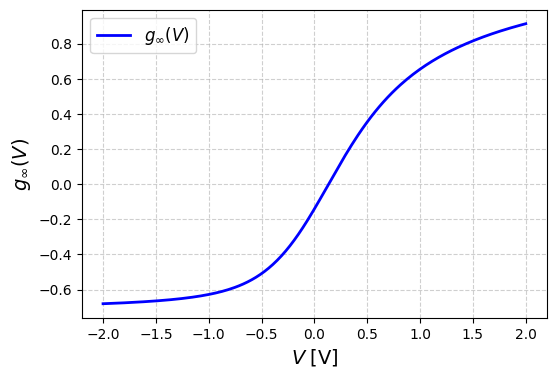

In [7]:
lookup_table = ginf_activator.get_lookup_table()

plt.figure(figsize=(6, 4))
plt.plot(
    lookup_table[0],
    lookup_table[1],
    label=r"$g_{\infty}(V)$",
    color="blue",
    linewidth=2,
)
plt.xlabel(r"$V \;[\text{V}]$", fontsize=14)
plt.ylabel(r"$g_{\infty}(V)$", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=12)
plt.savefig("output/ginf_activator_plot.pdf")
plt.savefig("output/ginf_activator_plot.png")

## ESN with Mackey-Glass time series

In [8]:
esn = EchoStateNetwork(
    input_dim=1,
    reservoir_size=10,
    output_dim=1,
    leaking_rate=1,
    step_size=0.1,
    time_scale=1,
    spectral_radius=0.9, #guarantee_ESP could change spectral radius if True
    sparsity=0.85,
    input_scaling=0.5,
    regularization=1e-6,
    weight_seed=35,
    activation=ginf_activator.activate,
    guarantee_ESP=True,
)

In [9]:
# Generate Mackey-Glass time series
dt_mg = 1
mg_series = MackeyGlassGenerator(tau=17, n=100000, n_samples=50000, dt=dt_mg)

# Normalize data between -1 and 1
mg_series = 2 * (mg_series - mg_series.min()) / (mg_series.max() - mg_series.min()) - 1

# Create input/output pairs for time series prediction
inputs = mg_series[:-1].reshape(-1, 1)
targets = mg_series[1:].reshape(-1, 1)

# Split into train and test sets
train_len = 40000
test_len = 4000
train_inputs = inputs[:train_len]
train_targets = targets[:train_len]
test_inputs = inputs[train_len : train_len + test_len]
test_targets = targets[train_len : train_len + test_len]

KeyboardInterrupt: 

In [ ]:
esn = EchoStateNetwork(
    input_dim=1,
    reservoir_size=200,
    output_dim=1,
    leaking_rate=0.9,
    step_size=dt_mg,
    time_scale=1/0.45,
    spectral_radius=0.9,
    sparsity=0.85,
    input_scaling=0.5,
    regularization=1e-6,
    washout = round(train_len/400),
    activation=ginf_activator.activate,
    guarantee_ESP=False,
)

# Train on first part of series
esn.fit(train_inputs, train_targets)

# Generate predictions on test set
teacher_ratio = 0.2
predictions = esn.predict(test_inputs, teacher_ratio=teacher_ratio)

# Calculate prediction error after network settled from np.zeroes initialization
print(f"{mse(test_targets, predictions) = }")

print(f"{esn.physical_length = }")
teacher_mode = int(len(test_targets)*teacher_ratio)
print(f"{teacher_mode = }")

This initilization might not have the echo state property


Training (time-step): 100%|██████████| 40100/40100 [00:00<00:00, 40761.39it/s]


mse(test_targets, predictions) = np.float64(0.37230870847147535)
esn.physical_length = np.float64(172.13259316477408)
teacher_mode = 800


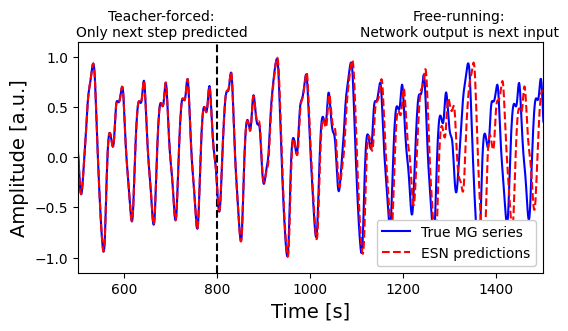

In [ ]:
cutoff_min = 500
cutoff_max = 1500

plt.figure(figsize=(6, 3))
plt.axvline(x=teacher_mode, linestyle="--", color='black')
plt.text(cutoff_min+180, 1.2, 'Teacher-forced:\nOnly next step predicted', dict(size=10), horizontalalignment='center')
plt.text(cutoff_max-180, 1.2, 'Free-running:\nNetwork output is next input', dict(size=10), horizontalalignment='center')
plt.plot(test_targets, label="True MG series", alpha=1, color='blue')
plt.plot(predictions, label="ESN predictions", linestyle="--", alpha=1, color='red')
# plt.title("Mackey-Glass Time Series Prediction (First 400 Steps)")
plt.xlabel("Time [s]", fontsize=14)
plt.ylabel("Amplitude [a.u.]", fontsize=14)
plt.xlim(cutoff_min, cutoff_max)
plt.ylim(-1.15, 1.15)
plt.legend(loc='lower right',framealpha=1)
plt.savefig("output/mg_prediction_plot.pdf")
plt.savefig("output/mg_prediction_plot.png")

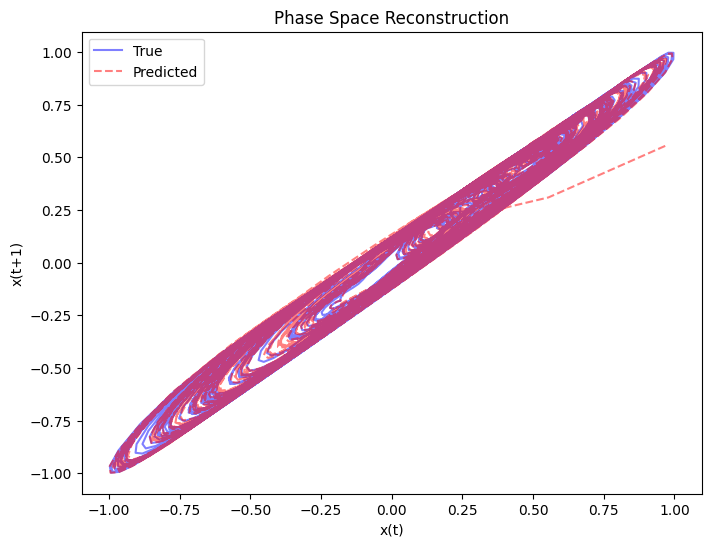

In [ ]:
# Plot phase space reconstruction
plt.figure(figsize=(8, 6))
plt.plot(
    test_targets[:-1][:5000],
    test_targets[1:][:5000],
    "b-",
    alpha=0.5,
    label="True",
)
plt.plot(
    predictions[:-1][:5000],
    predictions[1:][:5000],
    "r--",
    alpha=0.5,
    label="Predicted",
)
plt.title("Phase Space Reconstruction")
plt.xlabel("x(t)")
plt.ylabel("x(t+1)")
plt.legend()
plt.savefig("output/mg_phase_space_plot.pdf")
plt.savefig("output/mg_phase_space_plot.png")

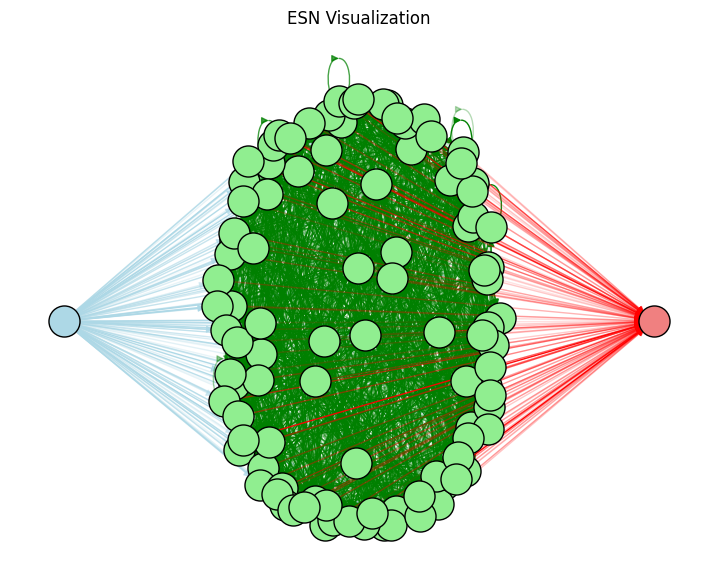

In [ ]:
visualize_reservoir(esn)

## ESN with Harmonic Wave time series

In [ ]:
# Generate synthetic data (simple sine wave prediction)
t = np.linspace(0, 80 * np.pi, 4000)
dt_harmonic = 80 * np.pi/4000
data = np.sin(t) * np.cos(1.4*t)

# Create input/output pairs for time series prediction
inputs = data[:-1].reshape(-1, 1)
targets = data[1:].reshape(-1, 1)

In [ ]:
# Initialize and train ESN
esn = EchoStateNetwork(
    input_dim=1,
    reservoir_size=20,
    output_dim=1,
    leaking_rate=0.9,
    step_size=dt_harmonic,
    time_scale=0.5,
    spectral_radius=0.8,
    sparsity=0.75,
    input_scaling=0.5,
    regularization=1e-6,
    washout=0,
    activation=ginf_activator.activate,
)

# Train on synthetic data
esn.fit(inputs, targets)

# Generate predictions
teacher_ratio=0.4
predictions = esn.predict(inputs, teacher_ratio=teacher_ratio)

# Calculate prediction error after network settled from np.zeroes initialization
print(f"{mse(targets, predictions) = }")

teacher_mode = int(len(targets)*teacher_ratio)
print(f"{teacher_mode = }")

Training (time-step): 100%|██████████| 3999/3999 [00:00<00:00, 68066.80it/s]

mse(targets, predictions) = np.float64(0.02853948511563766)
teacher_mode = 1599


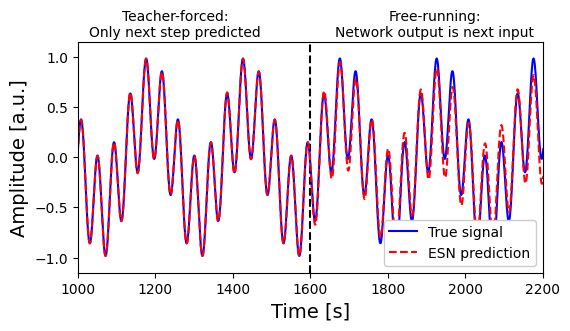

In [ ]:
cutoff_min = 1000
cutoff_max = 2200

plt.figure(figsize=(6, 3))
plt.axvline(x=teacher_mode, linestyle="--", color='black')
plt.text(cutoff_min+250, 1.2, 'Teacher-forced:\nOnly next step predicted', dict(size=10), horizontalalignment='center')
plt.text(cutoff_max-280, 1.2, 'Free-running:\nNetwork output is next input', dict(size=10), horizontalalignment='center')
plt.plot(targets, label="True signal",color='blue')
plt.plot(predictions, label="ESN prediction", linestyle="--",color='red')
plt.xlabel("Time [s]", fontsize=14)
plt.ylabel("Amplitude [a.u.]", fontsize=14)
plt.xlim(cutoff_min, cutoff_max)
plt.ylim(-1.15, 1.15)
plt.legend(loc='lower right',framealpha=1)
plt.savefig("output/sine_prediction_plot.pdf")
plt.savefig("output/sine_prediction_plot.png")

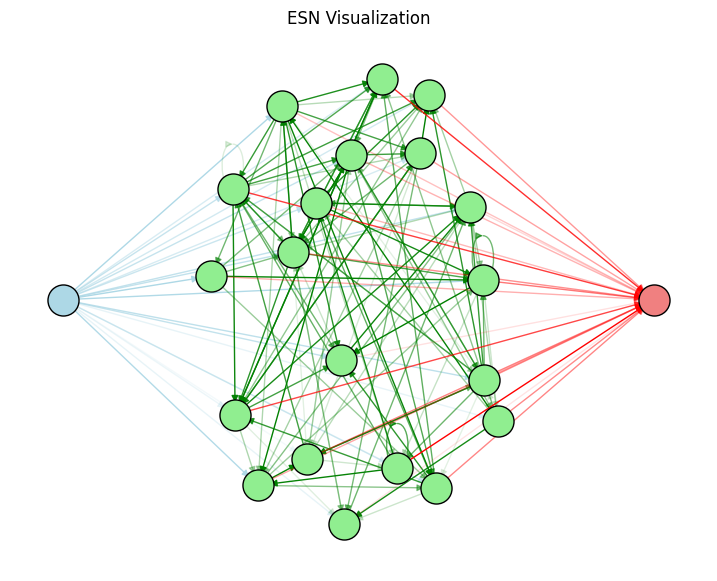

In [ ]:
visualize_reservoir(esn)

## ESN with Ventilator Pressure Prediction data

In [ ]:
import polars as pl

In [ ]:
data = pl.read_csv(r"data\ventilator-pressure-prediction\train.csv")[:100000]

data = data.to_dummies(columns=["R", "C"])

split = int(len(data) * 0.8)

train_x = data.drop('id','breath_id',"pressure")[:split].to_numpy()
train_y = data[["pressure"]][:split].to_numpy()
test_x = data.drop('id','breath_id',"pressure")[split:].to_numpy()
test_y = data[["pressure"]][split:].to_numpy()

data.drop('id','breath_id',"pressure")[:split].head()

R_20,R_5,R_50,C_10,C_20,C_50,time_step,u_in,u_out
u8,u8,u8,u8,u8,u8,f64,f64,i64
1,0,0,0,0,1,0.0,0.083334,0
1,0,0,0,0,1,0.033652,18.383041,0
1,0,0,0,0,1,0.067514,22.509278,0
1,0,0,0,0,1,0.101542,22.808822,0
1,0,0,0,0,1,0.135756,25.35585,0


In [ ]:
esn = EchoStateNetwork(
    input_dim=train_x.shape[1],
    reservoir_size=80,
    output_dim=train_y.shape[1],
    leaking_rate=0.66,
    step_size=0.18,
    time_scale=3.1,
    spectral_radius=0.16,
    sparsity=0.75,
    input_scaling=0.1,
    regularization=0.00047855525,
    washout = 100,
    activation=ginf_activator.activate,
    guarantee_ESP=True,
    progress_bar=True,
)

esn.fit(train_x, train_y)

Training (time-step): 100%|██████████| 80100/80100 [00:01<00:00, 73336.82it/s]


In [ ]:
predictions = esn.predict(test_x, teacher_ratio=1)
print(f"Test MSE: {mse(test_y, predictions)}")

Test MSE: 11.677479503321711


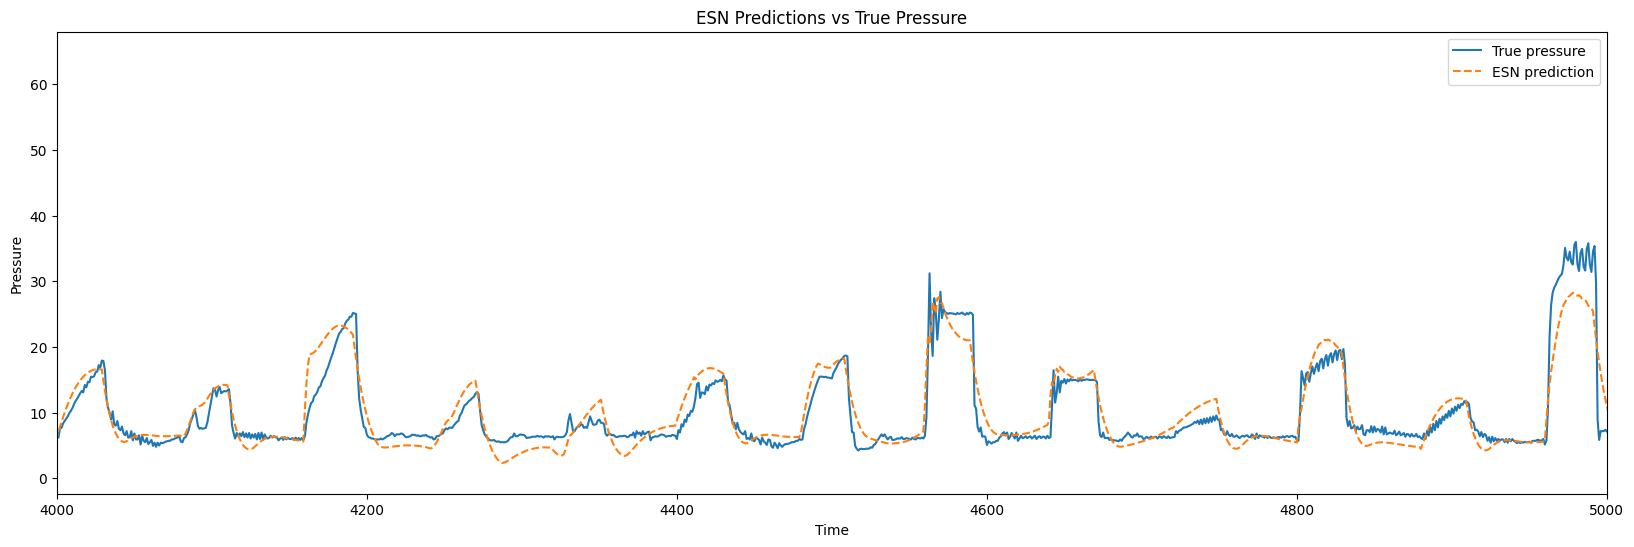

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(range(len(test_y)), test_y, label="True pressure")
plt.plot(range(len(test_y)), predictions, label="ESN prediction", linestyle="--",)
plt.title("ESN Predictions vs True Pressure")
plt.xlabel("Time")
plt.ylabel("Pressure")
plt.xlim(4000, 5000)
plt.legend()
plt.show()

## PWDB

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from random import randint
from ESN import PulseEchoStateNetwork
import numpy as np
from sklearn.utils import shuffle
from tqdm import tqdm

In [2]:
pathlist = Path(r'data/pulse-wave-database/PWs_csv/csv').glob('**/*.csv')
dfs = []
for path in tqdm(pathlist):
    df = pd.read_csv(path)
    _, df["filename"], df["Type"] = path.name.split("_")
    df["Type"] = df["Type"].str.replace(r"\.csv$", "", regex=True)
    dfs.append(df)
final_df = pd.concat(dfs, ignore_index=True)
data = pd.read_csv(r'data\pulse-wave-database\m.csv')
data.index = data.index + 1
df = final_df.merge(data, left_on="Subject Number", right_index=True, how="left")
pulse_columns = [col for col in df.columns if col.startswith(" pt")]
df["pulse"] = df[pulse_columns].apply(lambda row: row.dropna().tolist(), axis=1)

# Drop the original pulse columns
df = df.drop(columns=pulse_columns)
df = df[df.Type == 'P']
df = df.dropna(subset=['SI'])
df = df.reset_index(drop=True)

52it [00:10,  5.07it/s]


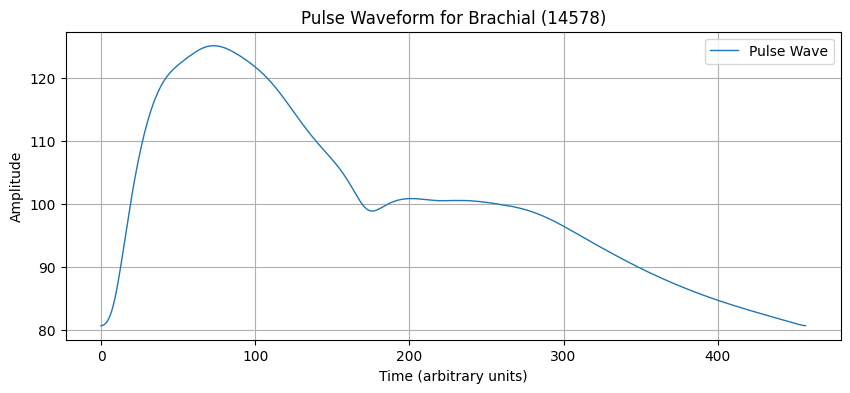

In [3]:
n = randint(0, len(df))
pulse_data = df.iloc[n]["pulse"]

plt.figure(figsize=(10, 4))
plt.plot(pulse_data, label="Pulse Wave", linewidth=1)
plt.xlabel("Time (arbitrary units)")
plt.ylabel("Amplitude")
plt.title(f"Pulse Waveform for {df.iloc[n]["filename"]} ({n})")
plt.legend()
plt.grid(True)
plt.show()

In [4]:
df_merged = df[["filename", "SI", "pulse"]].copy()
#df_merged["SI"]=(df_merged["SI"]-df_merged["SI"].min())/(df_merged["SI"].max()-df_merged["SI"].min())
df_merged = shuffle(df_merged, random_state=42)

train_samples = []
test_samples = []
num_samples = 100

unique_filenames = df_merged["filename"].unique()
for filename in unique_filenames:
    class_subset = df_merged[df_merged["filename"] == filename]

    train_samples.append(class_subset.iloc[:num_samples])
    test_samples.append(class_subset.iloc[num_samples:int(num_samples*1.2)])

train_set = pd.concat(train_samples).sample(frac=1, random_state=42)
test_set = pd.concat(test_samples).sample(frac=1, random_state=42)

train_x = list(train_set["pulse"])
train_y = train_set["SI"].values.reshape(-1, 1)
test_x = list(test_set["pulse"])
test_y = test_set["SI"].values.reshape(-1, 1)

In [5]:
esn = PulseEchoStateNetwork(
    input_dim=1,
    reservoir_size=1000,
    output_dim=1,
    leaking_rate=0.5,
    step_size=0.05,
    time_scale=4,
    spectral_radius=0.3,
    sparsity=0.9,
    input_scaling=2.3758091737239763e-6,
    regularization=0.00047855525,
    washout = 3,
    guarantee_ESP=False,
    progress_bar=True,
)

esn.fit(train_x, train_y)
predictions = esn.predict(test_x)

This initilization has the echo state property
Using Numba to simulate the reservoir for each pulse.


Training (pulses): 100%|██████████| 1300/1300 [01:29<00:00, 14.47it/s]


In [8]:
np.mean((predictions - test_y) ** 2)

np.float64(5.435794121982235)

One key detail is that in “pulses” mode, the code uses only the final reservoir state of each pulse to produce a single prediction. That single state often fails to capture large variations unless the reservoir is both large and driven strongly. In other words, if you have long pulses with strong peaks, reducing them to one final state makes the readout behave like an “average” of the pulse.

You can try the following adjustments:

Increase input scaling
A larger input_scaling can push reservoir states out of the mild range of tanh, leading to stronger dynamics.

Revisit guarantee_ESP
The Yildiz “guarantee” is conservative: it forces all initial reservoir weights to be nonnegative and then randomly flips signs. This dampens extremes. Try setting guarantee_ESP=False so weights have a more typical ESN distribution.

Use a bigger reservoir or smaller regularization
The final readout has to reconstruct the output from a single vector. If that vector is small or lacks variety, the predictions will be muted. A larger reservoir or weaker regularization (
𝜆
λ) can sometimes help.

Consider predicting multiple time steps
If your true target is a whole time series (with large peaks) rather than a single scalar per pulse, try the “timestep” mode. That way the readout can adapt at each time step and will not compress entire pulses into one state.

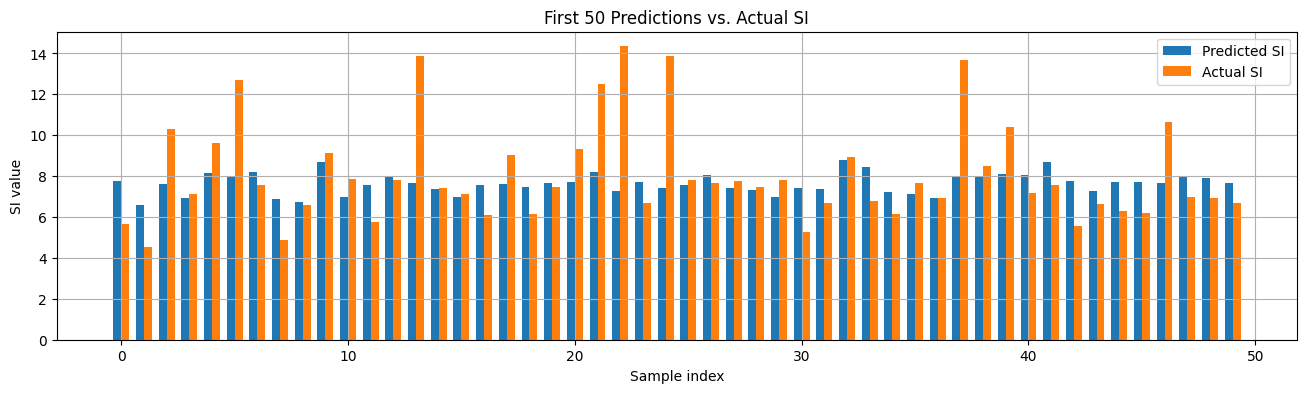

In [9]:
predictions = np.asarray(predictions).ravel()
test_y = np.asarray(test_y).ravel()

n = 50
indices = np.arange(n)
width = 0.35

plt.figure(figsize=(16, 4))
plt.bar(indices - width/2, predictions[:n], width=width, label='Predicted SI')
plt.bar(indices + width/2, test_y[:n], width=width, label='Actual SI')
plt.title('First 50 Predictions vs. Actual SI')
plt.xlabel('Sample index')
plt.ylabel('SI value')
plt.legend()
plt.grid(True)
plt.show()